# Phân cụm sinh viên theo điểm của họ bằng K-means

## 1. Nhập thư viện dữ liệu

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
print(os.listdir("input"))

['StudentsPerformance2.csv']


In [86]:
df = pd.read_csv("input/StudentsPerformance2.csv")

## 2. EDA

### 2.1. Phân tích dữ liệu

In [87]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72.0,72.0,74.0
1,female,group C,some college,standard,completed,69.0,90.0,88.0
2,female,group B,master's degree,standard,none,90.0,95.0,93.0
3,male,group A,associate's degree,free/reduced,none,47.0,183.0,44.0
4,male,group C,some college,standard,none,76.0,78.0,75.0


In [88]:
df.tail()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
995,female,group E,master's degree,standard,completed,88.0,99.0,95.0
996,male,group C,high school,free/reduced,none,62.0,55.0,55.0
997,female,group C,high school,free/reduced,completed,59.0,71.0,65.0
998,female,group D,some college,standard,completed,68.0,78.0,77.0
999,female,group D,some college,free/reduced,none,77.0,86.0,86.0


### 2.2 Mô tả dữ liệu

In [89]:
df.describe()

,math score,reading score,writing score
count,968.000000,964.000000,975.000000
mean,77.771694,77.678423,74.188718
std,85.858693,73.951208,59.446741
min,0.000000,17.000000,10.000000
25%,57.000000,60.000000,58.000000
50%,67.000000,71.000000,69.000000
75%,77.000000,80.000000,79.000000
max,952.000000,969.000000,941.000000


In [90]:
df.shape

(1000, 8)

### 2.3 Kiểm tra giá trị ngoại lệ và khuyết thiếu dữ liệu

- Xóa các giá trị điểm ngoại lệ (điểm < 0 hoặc điểm > 100)

In [91]:
print("Kích cỡ dữ liệu trước khi loại bỏ các giá trị lỗi:" , df['gender'].size)

Kích cỡ dữ liệu trước khi loại bỏ các giá trị lỗi: 1000


In [92]:
# Xác định các hàng có điểm nằm ngoài khoảng từ 0 đến 100 trong bất kỳ cột điểm nào
invalid_rows = df[(df['math score'] < 0) | (df['math score'] > 100) |
                      (df['reading score'] < 0) | (df['reading score'] > 100) |
                      (df['writing score'] < 0) | (df['writing score'] > 100)].index
df.drop(invalid_rows, inplace=True)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72.0,72.0,74.0
1,female,group C,some college,standard,completed,69.0,90.0,88.0
2,female,group B,master's degree,standard,none,90.0,95.0,93.0
4,male,group C,some college,standard,none,76.0,78.0,75.0
5,female,group B,associate's degree,standard,none,71.0,83.0,78.0


In [93]:
print("Kích cỡ dữ liệu sau khi loại bỏ các giá trị lỗi:" , df['gender'].size)

Kích cỡ dữ liệu sau khi loại bỏ các giá trị lỗi: 945


- Kiểm tra các giá trị trống

In [94]:
df.isnull().sum()

gender                          0
race/ethnicity                  0
parental level of education     0
lunch                           0
test preparation course         0
math score                     31
reading score                  36
writing score                  25
dtype: int64

In [95]:
df['math score'].fillna(df['math score'].mean(), inplace=True)
df['reading score'].fillna(df['reading score'].mean(), inplace=True)
df['writing score'].fillna(df['writing score'].mean(), inplace=True)
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

- Chi tiết dữ liệu

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 945 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       945 non-null    object 
 1   race/ethnicity               945 non-null    object 
 2   parental level of education  945 non-null    object 
 3   lunch                        945 non-null    object 
 4   test preparation course      945 non-null    object 
 5   math score                   945 non-null    float64
 6   reading score                945 non-null    float64
 7   writing score                945 non-null    float64
dtypes: float64(3), object(5)
memory usage: 66.4+ KB


### 2.4 Kiểm tra dữ liệu trùng lặp

In [97]:
df_d=df.duplicated().any()
df_d

False

### 2.5 Tiền xử lý (Preprocessing)

In [98]:
df['race/ethnicity'].value_counts()

race/ethnicity
group C    305
group D    243
group B    180
group E    136
group A     81
Name: count, dtype: int64

In [99]:
df['parental level of education'].value_counts()

parental level of education
some college          217
associate's degree    207
high school           183
some high school      169
bachelor's degree     112
master's degree        57
Name: count, dtype: int64

In [100]:
df['lunch'].value_counts()

lunch
standard        604
free/reduced    341
Name: count, dtype: int64

In [101]:
df['test preparation course'].value_counts()

test preparation course
none         602
completed    343
Name: count, dtype: int64

In [102]:
df['test preparation course'].replace("none", np.NaN, inplace=True)
df['test preparation course'].fillna(value="not completed", inplace=True)
df['test preparation course']

0      not completed
1          completed
2      not completed
4      not completed
5      not completed
           ...      
995        completed
996    not completed
997        completed
998        completed
999    not completed
Name: test preparation course, Length: 945, dtype: object

- Biểu diễn các giá trị trên biểu đồ

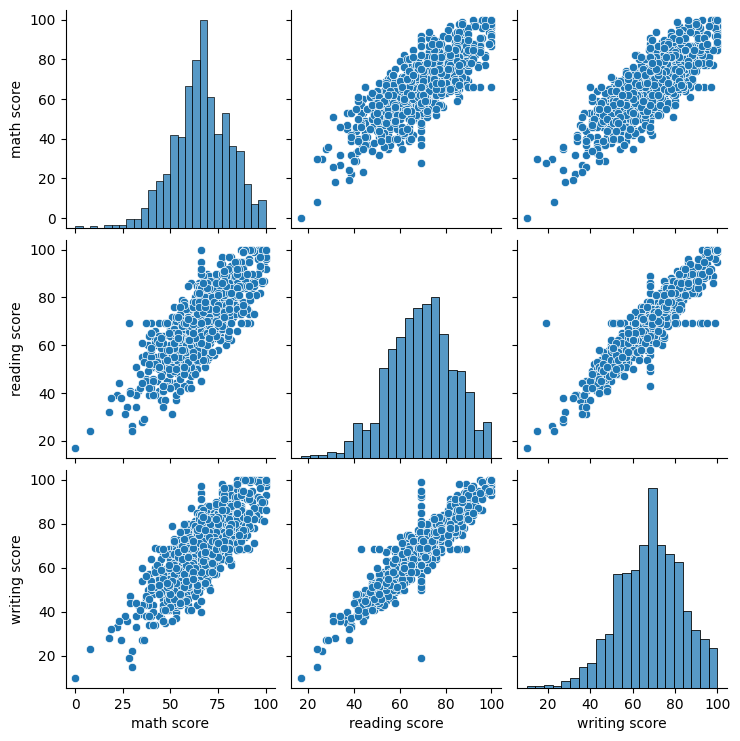

In [103]:
sns.pairplot(df.iloc[:,[5,6,7]])

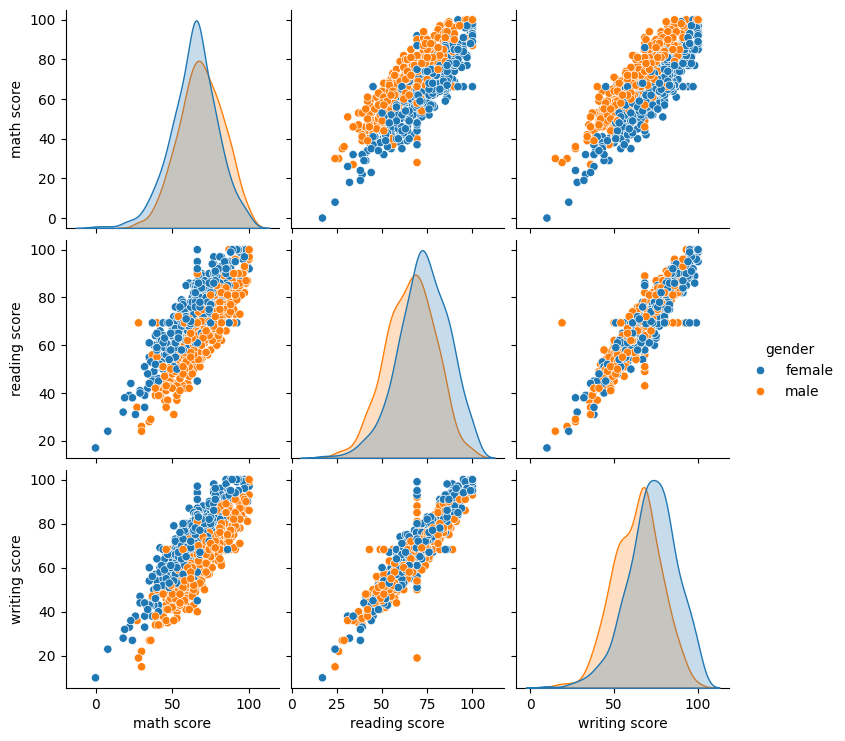

In [104]:
sns.pairplot(data = df,hue="gender")
plt.show()

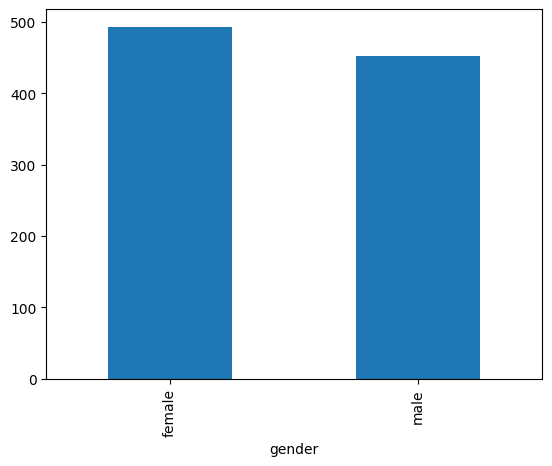

In [105]:
df ['gender'].value_counts().plot(kind='bar')
plt.show()

### 2.6. Chuẩn hóa dữ liệu (Standardization)

In [106]:
from sklearn.preprocessing import StandardScaler
X=df.iloc[:,[5,6,7]].values
sc_x=StandardScaler()
X=sc_x.fit_transform(X)
X

array([[ 0.3832899 ,  0.18488214,  0.38302805],
       [ 0.1822991 ,  1.44742039,  1.31703057],
       [ 1.58923472,  1.79812546,  1.6506029 ],
       ...,
       [-0.48767025,  0.11474113, -0.21740214],
       [ 0.11530216,  0.60572823,  0.58317145],
       [ 0.71827457,  1.16685633,  1.18360164]])

## 3. K-means

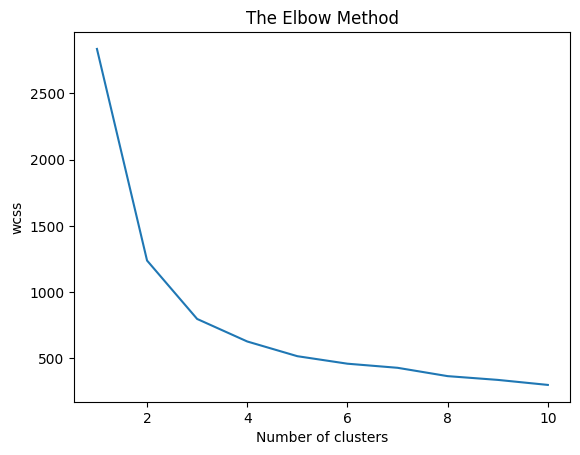

In [107]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init="k-means++", random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("wcss")
plt.show()

In [108]:
kmeans= KMeans(n_clusters=3, init = "k-means++", random_state=0)
y_kmeans= kmeans.fit_predict(X)
df['cluster'] = y_kmeans
df.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,cluster
0,female,group B,bachelor's degree,standard,not completed,72.0,72.0,74.0,1
1,female,group C,some college,standard,completed,69.0,90.0,88.0,0
2,female,group B,master's degree,standard,not completed,90.0,95.0,93.0,0
4,male,group C,some college,standard,not completed,76.0,78.0,75.0,0
5,female,group B,associate's degree,standard,not completed,71.0,83.0,78.0,0
6,female,group B,some college,standard,completed,88.0,95.0,92.0,0
7,male,group B,some college,free/reduced,not completed,40.0,43.0,39.0,2
8,male,group D,high school,free/reduced,completed,64.0,64.0,67.0,1
9,female,group B,high school,free/reduced,not completed,38.0,60.0,50.0,2
10,male,group C,associate's degree,standard,not completed,58.0,54.0,52.0,2


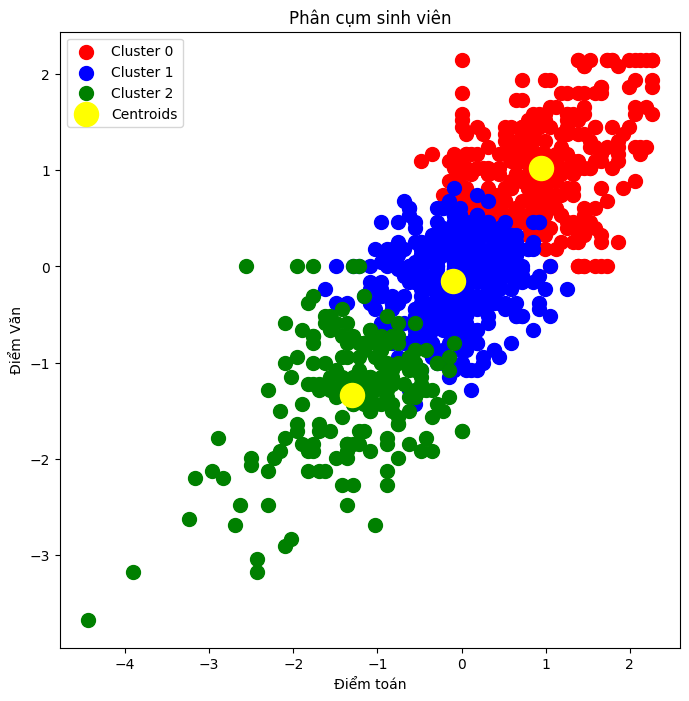

In [109]:
plt.figure(figsize=(8,8))
plt.scatter(X[y_kmeans==0,0], X[y_kmeans==0,1], s=100, c="red", label= "Cluster 0")
plt.scatter(X[y_kmeans==1,0], X[y_kmeans==1,1], s=100, c="blue", label= "Cluster 1")
plt.scatter(X[y_kmeans==2,0], X[y_kmeans==2,1], s=100, c="green", label= "Cluster 2")
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c="yellow", label="Centroids")
plt.title("Phân cụm sinh viên")
plt.xlabel("Điểm toán")
plt.ylabel("Điểm Văn")
plt.legend()
plt.show()

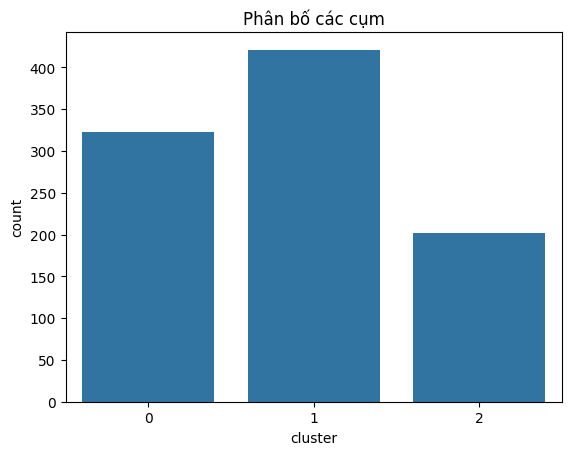

In [110]:
pl = sns.countplot(x=df["cluster"])
pl.set_title("Phân bố các cụm")
plt.show()

In [111]:
cluster_means = df.groupby('cluster')[['math score', 'reading score', 'writing score']].mean()
cluster_means

,math score,reading score,writing score
cluster,,,
0,80.358730,83.992675,83.330907
1,64.716342,67.293698,66.525886
2,47.091871,50.360498,47.844146


In [112]:
gender_dis = df.groupby(['cluster', 'gender']).size().unstack(fill_value=0)
gender_dis

gender,female,male
cluster,,
0,194,128
1,213,208
2,86,116


In [113]:
lunch_dis = df.groupby(['cluster', 'lunch']).size().unstack(fill_value=0)
lunch_dis

lunch,free/reduced,standard
cluster,,
0,78,244
1,141,280
2,122,80
